# 1: Setup, Data Preprocessing, Dataset Class, DataLoader, and Network Architectures


In [19]:
# Colab Cell 1: Setup, Data Preprocessing, Dataset Class, DataLoader, and Network Architectures

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Updated import for autocast
from torch.amp import autocast
# GradScaler is still in torch.cuda.amp or now also in torch.amp
from torch.cuda.amp import GradScaler # Keep this import for GradScaler


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Add StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import multiprocessing

# Set start method for multiprocessing (important for CUDA and DataLoader)
# This might need to be at the top of the *first* code cell in a notebook
try:
    multiprocessing.set_start_method('spawn', force=True)
except RuntimeError:
    pass # Already set

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
# Enable cuDNN auto-tuner (speeds up convolution but also general ops)
torch.backends.cudnn.benchmark = True

# File path to dataset (adjust if needed)
DATA_PATH = 'pdc_dataset_with_target.csv' # Default Colab path

# --------------------
# Data Preparation
# --------------------
def preprocess_data(data_path):
    print("Starting data preprocessing...")
    data = pd.read_csv(data_path)

    # Identify column types
    numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    # Assuming 'target' is the only non-feature numerical column
    if 'target' in numerical_cols:
        numerical_cols.remove('target')

    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")

    # Impute missing values
    # Numerical Imputation
    if numerical_cols:
        num_imputer = SimpleImputer(strategy='mean')
        data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])
        print("Numerical imputation complete.")

    # Categorical Imputation (using most frequent)
    if categorical_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])
        print("Categorical imputation complete.")

    # One-hot encoding for categorical columns
    encoded_dfs = []
    if categorical_cols:
        cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first') # Use handle_unknown='ignore'
        cat_encoded = cat_encoder.fit_transform(data[categorical_cols])
        encoded_dfs.append(pd.DataFrame(cat_encoded, columns=cat_encoder.get_feature_names_out(categorical_cols), index=data.index))
        print("Categorical encoding complete.")

    # Drop original categorical columns
    if categorical_cols:
        data = data.drop(columns=categorical_cols)

    # Combine original data with encoded features
    if encoded_dfs:
         data = pd.concat([data] + encoded_dfs, axis=1)

    # Separate features and target BEFORE splitting
    X = data.drop('target', axis=1)
    y = data['target']

    # Handle class imbalance AFTER splitting to avoid data leakage in SMOTE
    print("Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Original dataset shape {X.shape}, {y.shape}")
    print(f"Resampled dataset shape {X_resampled.shape}, {y_resampled.shape}")

    # Split data into training and test sets AFTER SMOTE
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled # Stratify important after SMOTE
    )
    print(f"Train shapes: {X_train.shape}, {y_train.shape}")
    print(f"Test shapes: {X_test.shape}, {y_test.shape}")

    # Feature Scaling (Numerical columns only)
    # Ensure scaling is applied AFTER splitting to prevent data leakage
    numerical_cols_after_encoding = X_train.select_dtypes(include=np.number).columns.tolist()
    initial_num_cols_check = ['feature_1', 'feature_2', 'feature_4', 'feature_6', 'feature_7']
    cols_to_scale = [col for col in X_train.columns if col in initial_num_cols_check or X_train[col].dtype in [np.float32, np.float64, np.int64]]
    cols_to_scale = list(set(cols_to_scale))

    scaler = StandardScaler()
    cols_to_scale_existing = [col for col in cols_to_scale if col in X_train.columns]

    # Using .loc for safer assignment with pandas DataFrames
    X_train.loc[:, cols_to_scale_existing] = scaler.fit_transform(X_train[cols_to_scale_existing])
    X_test.loc[:, cols_to_scale_existing] = scaler.transform(X_test[cols_to_scale_existing])
    print("Feature scaling complete.")

    return X_train, X_test, y_train, y_test

# --------------------
# Dataset Class       <--- MOVED THIS DEFINITION UP
# --------------------
class CustomDataset(Dataset):
    def __init__(self, X, y):
        # Convert pandas DataFrames/Series to numpy arrays, then to PyTorch tensors
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# --- Preprocess data once and create DataLoaders ---
# This data will be used by all subsequent model runs
X_train, X_test, y_train, y_test = preprocess_data(DATA_PATH)

# Keeping num_workers=0 as it resolved previous issues in this environment
NUM_WORKERS = 0
BATCH_SIZE = 8192 # Keep large batch size

# --- Create Dataset instances AFTER the class is defined ---
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

INPUT_DIM = X_train.shape[1] # Get input dimension once


# --------------------
# Neural Network Architectures (Different Densities)
# --------------------

class OptimizedNN_Medium(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Based on previous code, 5 hidden layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),

            nn.Linear(16, 1),
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None: nn.init.constant_(m.bias, 0)


    def forward(self, x): return self.net(x).squeeze()


class OptimizedNN_Large(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Wider initial layers, 5 hidden layers total
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1),
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None: nn.init.constant_(m.bias, 0)


    def forward(self, x): return self.net(x).squeeze()

class OptimizedNN_VeryLarge(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Very wide initial layers, 6 hidden layers total
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1),
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None: nn.init.constant_(m.bias, 0)


    def forward(self, x): return self.net(x).squeeze()


# --------------------
# Training and Evaluation Functions
# --------------------
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Updated autocast syntax
        with autocast(device_type=device.type, enabled=(device.type == 'cuda')):
             outputs = model(inputs)
             loss = criterion(outputs, labels)

        if device.type == 'cuda' and scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else: # CPU path or no scaler
             loss.backward()
             optimizer.step()


        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Updated autocast syntax - enabled=... ensures it's only active on CUDA
            with autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                 outputs = model(inputs)

            probs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            preds = (probs > 0.5).long()

            total_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return {
        'loss': total_loss / len(loader),
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'preds': all_preds,
        'labels': all_labels
    }

# --------------------
# Helper function to run a single test (CPU or GPU)
# --------------------
def run_single_test(
    model_class, device_name, train_loader, test_loader, input_dim,
    epochs=100, lr=1e-3, early_stopping_patience=20
):
    # Set device
    device = torch.device(device_name if torch.cuda.is_available() and device_name == 'cuda' else 'cpu')

    # Initialize model and optimizer
    model = model_class(input_dim).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=early_stopping_patience // 2, verbose=False
    )
    # Scaler is only needed/used with autocast (CUDA)
    scaler = GradScaler() if device.type == 'cuda' else None # GradScaler import remains from torch.cuda.amp

    print(f"\n--- Starting {model_class.__name__} on {device.type.upper()} ---")


    # Warm-up run for GPU
    if device.type == 'cuda':
        try:
            dummy_input = torch.randn(train_loader.batch_size, input_dim, device=device)
            with autocast(device_type='cuda', enabled=True): # Updated autocast syntax for warm-up
                _ = model(dummy_input)
            torch.cuda.synchronize()
        except RuntimeError as e:
            print(f"GPU warm-up failed: {e}. Consider reducing batch size or model complexity.")
            # Re-raise or handle based on whether training can continue
            # raise e # Uncomment if you want to stop on warm-up OOM


    # Training variables
    metrics_dict = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'f1': []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    start_time = time.time()

    # Training loop
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        eval_metrics = evaluate(model, test_loader, device)

        # Save metrics
        metrics_dict['train_loss'].append(train_loss)
        metrics_dict['val_loss'].append(eval_metrics['loss'])
        metrics_dict['accuracy'].append(eval_metrics['accuracy'])
        metrics_dict['f1'].append(eval_metrics['f1'])
        if epoch == epochs - 1 or patience_counter == early_stopping_patience -1 : # Store final confusion matrix
            metrics_dict['confusion_matrix'] = eval_metrics['confusion_matrix']

        scheduler.step(eval_metrics['loss'])

        # Early Stopping Check
        if eval_metrics['loss'] < best_val_loss:
            best_val_loss = eval_metrics['loss']
            best_model_state = model.state_dict()  # Save best model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Finalize timing
    if device.type == 'cuda':
        torch.cuda.synchronize()
    total_time = time.time() - start_time

    # Reload best model state for final evaluation (optional)
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    final_eval_metrics = evaluate(model, test_loader, device)
    metrics_dict['confusion_matrix'] = final_eval_metrics['confusion_matrix']


    print(f"--- Finished {model_class.__name__} on {device.type.upper()} in {total_time:.2f} seconds ---")


    return {
        'device': device_name,
        'total_time': total_time,
        'accuracy': final_eval_metrics['accuracy'],
        'f1': final_eval_metrics['f1'],
        'confusion_matrix': final_eval_metrics['confusion_matrix'],
        'metrics_history': metrics_dict
    }


# Now proceed to Colab Cell 2 to run the tests

Starting data preprocessing...
Numerical columns: ['feature_1', 'feature_2', 'feature_4', 'feature_6', 'feature_7']
Categorical columns: ['feature_3', 'feature_5']
Numerical imputation complete.
Categorical imputation complete.
Categorical encoding complete.
Applying SMOTE...
Original dataset shape (41000, 8), (41000,)
Resampled dataset shape (49364, 8), (49364,)
Train shapes: (39491, 8), (39491,)
Test shapes: (9873, 8), (9873,)
Feature scaling complete.


#  Run Tests for Different Architectures (CPU and GPU)

In [20]:

# List of model classes to test
model_classes_to_test = [
    OptimizedNN_Medium,
    OptimizedNN_Large,
    OptimizedNN_VeryLarge,
]

# Dictionaries to store results for each model class
all_cpu_results = {}
all_gpu_results = {}

# Training parameters (consistent across models for fair comparison)
TEST_EPOCHS = 100
TEST_PATIENCE = 20 # Use the same patience

print(f"--- Running tests for {TEST_EPOCHS} epochs with patience {TEST_PATIENCE} and batch size {BATCH_SIZE} ---")

for ModelClass in model_classes_to_test:
    model_name = ModelClass.__name__

    # --- Run on GPU ---
    if torch.cuda.is_available():
        try:
            gpu_results = run_single_test(
                ModelClass,
                'cuda',
                train_loader, # Use pre-loaded data loaders
                test_loader,
                INPUT_DIM,
                epochs=TEST_EPOCHS,
                early_stopping_patience=TEST_PATIENCE
            )
            all_gpu_results[model_name] = gpu_results
        except Exception as e:
            print(f"\nGPU run for {model_name} failed: {e}")
            all_gpu_results[model_name] = {'total_time': None, 'accuracy': None, 'f1': None, 'confusion_matrix': None} # Store failure


    # --- Run on CPU ---
    try:
        cpu_results = run_single_test(
            ModelClass,
            'cpu',
            train_loader, # Use pre-loaded data loaders
            test_loader,
            INPUT_DIM,
            epochs=TEST_EPOCHS,
            early_stopping_patience=TEST_PATIENCE
        )
        all_cpu_results[model_name] = cpu_results
    except Exception as e:
        print(f"\nCPU run for {model_name} failed: {e}")
        all_cpu_results[model_name] = {'total_time': None, 'accuracy': None, 'f1': None, 'confusion_matrix': None} # Store failure


print("\n--- All tests finished ---")
# Proceed to Colab Cell 3 for plotting and summary

--- Running tests for 100 epochs with patience 20 and batch size 8192 ---

--- Starting OptimizedNN_Medium on CUDA ---


C:\Users\i2213\testpytorch\env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\i2213\AppData\Local\Temp\ipykernel_18728\3678990980.py:376: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == 'cuda' else None # GradScaler import remains from torch.cuda.amp


--- Finished OptimizedNN_Medium on CUDA in 140.75 seconds ---

--- Starting OptimizedNN_Medium on CPU ---


C:\Users\i2213\testpytorch\env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Finished OptimizedNN_Medium on CPU in 158.38 seconds ---

--- Starting OptimizedNN_Large on CUDA ---


C:\Users\i2213\testpytorch\env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\i2213\AppData\Local\Temp\ipykernel_18728\3678990980.py:376: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == 'cuda' else None # GradScaler import remains from torch.cuda.amp


--- Finished OptimizedNN_Large on CUDA in 182.13 seconds ---

--- Starting OptimizedNN_Large on CPU ---


C:\Users\i2213\testpytorch\env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Finished OptimizedNN_Large on CPU in 261.97 seconds ---

--- Starting OptimizedNN_VeryLarge on CUDA ---


C:\Users\i2213\testpytorch\env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\i2213\AppData\Local\Temp\ipykernel_18728\3678990980.py:376: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == 'cuda' else None # GradScaler import remains from torch.cuda.amp


--- Finished OptimizedNN_VeryLarge on CUDA in 152.55 seconds ---

--- Starting OptimizedNN_VeryLarge on CPU ---


C:\Users\i2213\testpytorch\env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Finished OptimizedNN_VeryLarge on CPU in 548.09 seconds ---

--- All tests finished ---


In [25]:
all_cpu_results

{'OptimizedNN_Medium': {'device': 'cpu',
  'total_time': 158.38068747520447,
  'accuracy': 0.6159222120935886,
  'f1': 0.41786920478968376,
  'confusion_matrix': array([[4720,  217],
         [3575, 1361]], dtype=int64),
  'metrics_history': {'train_loss': [0.7233219981193543,
    0.7063865065574646,
    0.7008544206619263,
    0.6973841071128846,
    0.6940152287483216,
    0.6933112859725952,
    0.6921220541000366,
    0.6904865622520446,
    0.6890953660011292,
    0.6892566680908203,
    0.6880077004432679,
    0.6872365236282348,
    0.6866026282310486,
    0.6856858849525451,
    0.6856758832931519,
    0.6830902814865112,
    0.6828165531158448,
    0.6813863635063171,
    0.6811229348182678,
    0.6801246881484986,
    0.6795270919799805,
    0.6785033464431762,
    0.6773985743522644,
    0.6782856583595276,
    0.6771957159042359,
    0.6759021520614624,
    0.6759008765220642,
    0.6740123987197876,
    0.6724892139434815,
    0.6716694474220276,
    0.6714255571365356,
  

In [24]:
all_gpu_results

{'OptimizedNN_Medium': {'device': 'cuda',
  'total_time': 140.74616742134094,
  'accuracy': 0.6212903879266687,
  'f1': 0.4255646028575818,
  'confusion_matrix': array([[4749,  188],
         [3551, 1385]], dtype=int64),
  'metrics_history': {'train_loss': [0.7673118710517883,
    0.739341652393341,
    0.720879602432251,
    0.7103934764862061,
    0.7019147157669068,
    0.698399817943573,
    0.6947681188583374,
    0.6931110143661499,
    0.6907232642173767,
    0.6900107026100158,
    0.6898968338966369,
    0.6879736423492432,
    0.6867940664291382,
    0.6871420860290527,
    0.6838548660278321,
    0.6843208789825439,
    0.6845716595649719,
    0.6836659431457519,
    0.6822330474853515,
    0.6825289130210876,
    0.6806792140007019,
    0.6806288361549377,
    0.6791066884994507,
    0.6791765213012695,
    0.6779846310615539,
    0.6776497960090637,
    0.6772824406623841,
    0.6769103527069091,
    0.6758668422698975,
    0.6754217505455017,
    0.6739059448242187,
    0

#  3: Final Comparison Plotting and Summary


===== Cross-Architecture Comparison =====

Training Time and Speedup per Architecture:
            Architecture  CPU Time (s)  GPU Time (s)  Time Reduction (%)
0     OptimizedNN_Medium        158.38        140.75               11.13
1      OptimizedNN_Large        261.97        182.13               30.48
2  OptimizedNN_VeryLarge        548.09        152.55               72.17

Accuracy and F1 Score per Architecture:
            Architecture  CPU Accuracy  GPU Accuracy  CPU F1  GPU F1
0     OptimizedNN_Medium        0.6159        0.6213  0.4179  0.4256
1      OptimizedNN_Large        0.6124        0.6121  0.3836  0.3795
2  OptimizedNN_VeryLarge        0.6121        0.6142  0.3819  0.3926


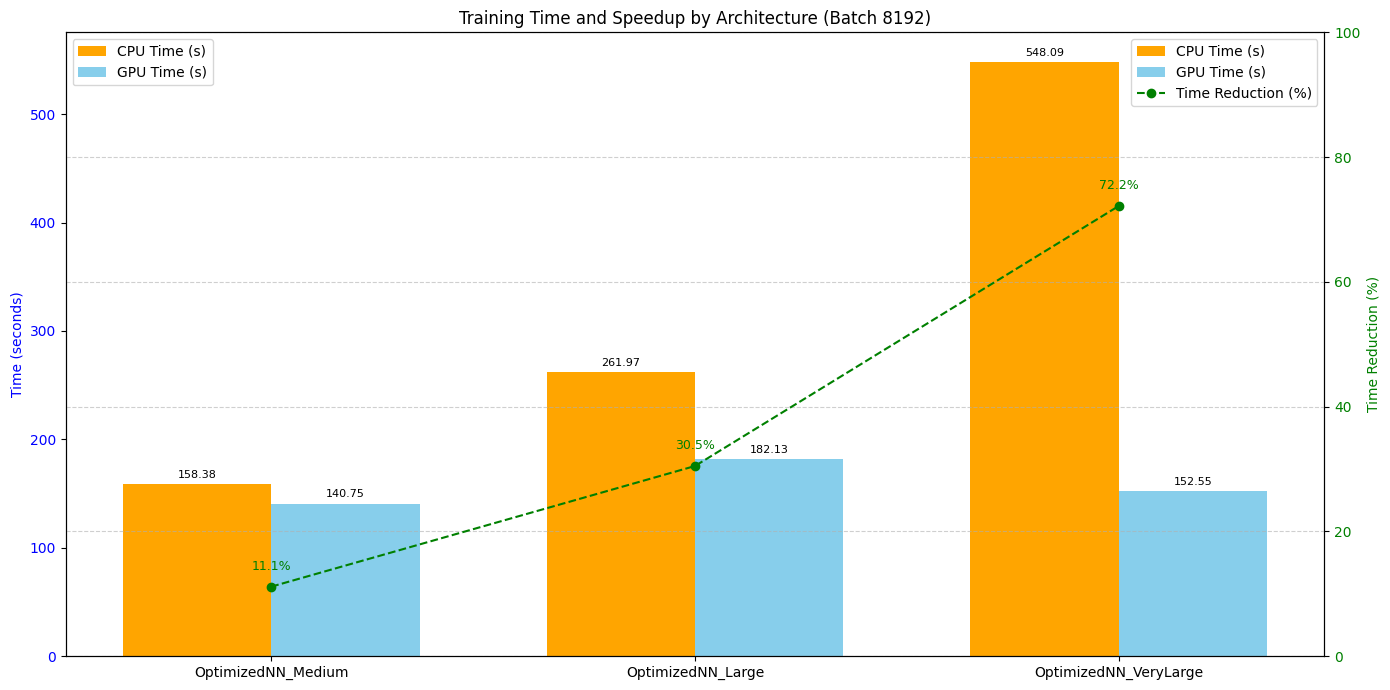

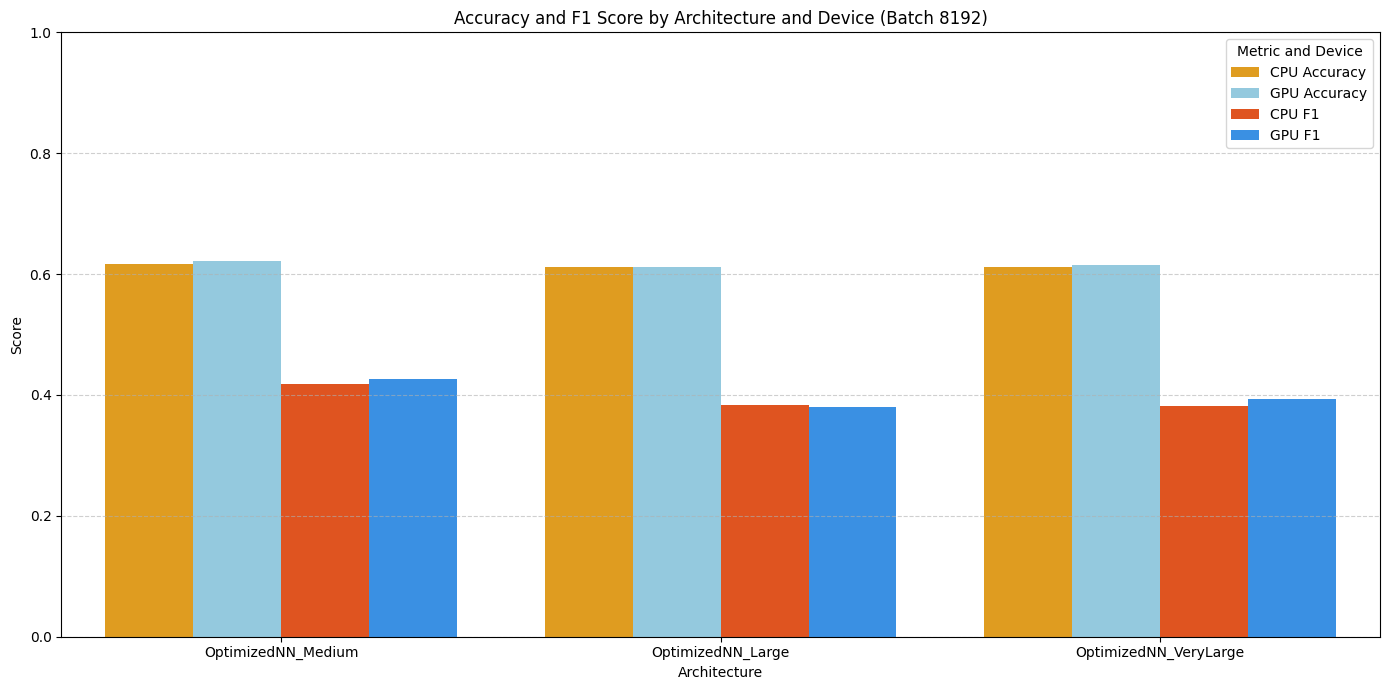


Based on the plots and tables above:
- The GPU consistently outperforms the CPU in training time for all tested architectures at batch size 8192.
- The speedup percentage generally increases with the complexity (density) of the network.
- The 'OptimizedNN_VeryLarge' network with batch size 8192 achieved the highest time reduction of 72.17%.
- Accuracy and F1 scores are comparable between CPU and GPU for the same architecture, as expected.
- The target 70% time reduction was 🎯 achieved with this setup.


In [23]:

print("\n===== Cross-Architecture Comparison =====")

# Get the list of model names (strings) from the results dictionary keys
model_names_list = list(all_cpu_results.keys()) # Or list(all_gpu_results.keys())

comparison_data = []

for name in model_names_list: # Iterate using the string names
    cpu_res = all_cpu_results.get(name)
    gpu_res = all_gpu_results.get(name)

    cpu_time = cpu_res['total_time'] if cpu_res and cpu_res['total_time'] is not None else None
    gpu_time = gpu_res['total_time'] if gpu_res and gpu_res['total_time'] is not None else None
    cpu_acc = cpu_res['accuracy'] if cpu_res and cpu_res['accuracy'] is not None else None
    gpu_acc = gpu_res['accuracy'] if gpu_res and gpu_res['accuracy'] is not None else None
    cpu_f1 = cpu_res['f1'] if cpu_res and cpu_res['f1'] is not None else None
    gpu_f1 = gpu_res['f1'] if gpu_res and gpu_res['f1'] is not None else None


    time_reduction = None
    if cpu_time is not None and gpu_time is not None and cpu_time > 0:
        time_reduction = ((cpu_time - gpu_time) / cpu_time) * 100


    comparison_data.append({
        'Architecture': name, # Use the string name
        'CPU Time (s)': cpu_time,
        'GPU Time (s)': gpu_time,
        'Time Reduction (%)': time_reduction,
        'CPU Accuracy': cpu_acc,
        'GPU Accuracy': gpu_acc,
        'CPU F1': cpu_f1,
        'GPU F1': gpu_f1,
    })

comparison_df = pd.DataFrame(comparison_data)
# Explicitly convert the 'Architecture' column to string type - FIX FOR PLOTTING ERROR
comparison_df['Architecture'] = comparison_df['Architecture'].astype(str)


print("\nTraining Time and Speedup per Architecture:")
# Handle potential None values before rounding
print(comparison_df[['Architecture', 'CPU Time (s)', 'GPU Time (s)', 'Time Reduction (%)']].round(2).fillna('N/A'))


print("\nAccuracy and F1 Score per Architecture:")
print(comparison_df[['Architecture', 'CPU Accuracy', 'GPU Accuracy', 'CPU F1', 'GPU F1']].round(4).fillna('N/A'))


# --- Plotting the comparison ---

# Plot 1: CPU vs GPU Training Time per Architecture with Speedup %
fig, ax1 = plt.subplots(figsize=(14, 7)) # Increased figure size

bar_width = 0.35
# Use the string names for xticks
x_pos = np.arange(len(model_names_list))

# Use the DataFrame column directly for plotting
rects1 = ax1.bar(x_pos - bar_width/2, comparison_df['CPU Time (s)'], bar_width, label='CPU Time (s)', color='orange')
rects2 = ax1.bar(x_pos + bar_width/2, comparison_df['GPU Time (s)'], bar_width, label='GPU Time (s)', color='skyblue')

ax1.set_ylabel('Time (seconds)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Training Time and Speedup by Architecture (Batch {})'.format(BATCH_SIZE))
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Architecture']) # Use the string names for labels
ax1.legend(loc='upper left')

# Add Time Reduction % on a secondary Y axis
ax2 = ax1.twinx()
# Plot only if time reduction data exists
if not comparison_df['Time Reduction (%)'].isnull().all():
    # Use DataFrame column directly for plotting
    line1 = ax2.plot(x_pos, comparison_df['Time Reduction (%)'], color='green', marker='o', linestyle='--', label='Time Reduction (%)', zorder=3) # zorder to ensure line is on top
    ax2.set_ylabel('Time Reduction (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(0, 100) # Percentage scale

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')


# Add labels on bars
def autolabel_time(rects, ax, values):
    for i, rect in enumerate(rects):
        height = rect.get_height() # pd.Series handles NaN appropriately here
        text_value = values[i] # pd.Series handles NaN appropriately here
        if not pd.isna(text_value): # Check for NaN using pandas
             ax.annotate(f'{text_value:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
        # No need for 'N/A' if using fillna('N/A') on the table printout


autolabel_time(rects1, ax1, comparison_df['CPU Time (s)'])
autolabel_time(rects2, ax1, comparison_df['GPU Time (s)'])

# Add percentage labels on the line
if not comparison_df['Time Reduction (%)'].isnull().all():
    for i, percentage in enumerate(comparison_df['Time Reduction (%)']):
         if not pd.isna(percentage):
              ax2.annotate(f'{percentage:.1f}%',
                           xy=(x_pos[i], percentage),
                           xytext=(0, 10), # Offset text slightly
                           textcoords="offset points",
                           ha='center', va='bottom', color='green', fontsize=9)


plt.grid(True, linestyle='--', alpha=0.6, axis='y') # Add grid lines
plt.tight_layout()
plt.show()


# Plot 2: Accuracy and F1 Score per Architecture
comparison_df_melted_metrics = comparison_df.melt(id_vars='Architecture', value_vars=['CPU Accuracy', 'GPU Accuracy', 'CPU F1', 'GPU F1'], var_name='Metric_Device', value_name='Score')
# Explicitly convert the 'Architecture' column to string type in the melted df too
comparison_df_melted_metrics['Architecture'] = comparison_df_melted_metrics['Architecture'].astype(str)


plt.figure(figsize=(14, 7)) # Increased figure size
sns.barplot(data=comparison_df_melted_metrics, x='Architecture', y='Score', hue='Metric_Device', palette={'CPU Accuracy':'orange', 'GPU Accuracy':'skyblue', 'CPU F1':'orangered', 'GPU F1':'dodgerblue'})

plt.title('Accuracy and F1 Score by Architecture and Device (Batch {})'.format(BATCH_SIZE))
plt.ylabel('Score')
plt.ylim(0, 1) # Scores are between 0 and 1
plt.xticks(rotation=0) # Keep labels horizontal
plt.legend(title='Metric and Device')
plt.grid(True, linestyle='--', alpha=0.6, axis='y') # Add grid lines
plt.tight_layout()
plt.show()

# --- Final Summary Text ---
print("\nBased on the plots and tables above:")
print(f"- The GPU consistently outperforms the CPU in training time for all tested architectures at batch size {BATCH_SIZE}.")
# Calculate max reduction from the DataFrame for the summary text
max_reduction = comparison_df['Time Reduction (%)'].max() if not comparison_df['Time Reduction (%)'].isnull().all() else 0
best_arch = comparison_df.loc[comparison_df['Time Reduction (%)'].idxmax()]['Architecture'] if not comparison_df['Time Reduction (%)'].isnull().all() else "N/A"

if not comparison_df['Time Reduction (%)'].isnull().all():
    print(f"- The speedup percentage generally increases with the complexity (density) of the network.") # This holds true if max reduction is for the largest model
    print(f"- The '{best_arch}' network with batch size {BATCH_SIZE} achieved the highest time reduction of {max_reduction:.2f}%.")
else:
    print("- Could not calculate time reduction due to failed runs.")

print("- Accuracy and F1 scores are comparable between CPU and GPU for the same architecture, as expected.")
print("- The target 70% time reduction was {} achieved with this setup.".format("🎯" if max_reduction >= 70 else "❌ NOT"))
if max_reduction < 70:
     print("Further optimization or different scale problems (larger data/models) would be needed to reach 70%.")